# Project 2: Enhancer Classification Problem

In [30]:
import gzip
from Bio import SeqIO
from Bio.Seq import Seq
from collections import defaultdict
import random
from sklearn.metrics import roc_auc_score
import itertools
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import pandas as pd
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

### Loading the data

In [2]:
def load_fasta(file_path):
    sequences = []
    with open(file_path, "r") as fasta_file:
        for record in SeqIO.parse(fasta_file, "fasta"):
            sequences.append({"id": record.id, "sequence": str(record.seq).upper()})
    return pd.DataFrame(sequences)

In [3]:
def load_tsv(file_path):
    with gzip.open(file_path, "rt") as f:
        df_ = pd.read_csv(f, sep="\t")
    return df_

In [4]:
genomes = load_fasta("data/GRCh38.p14.genome.fa")
experiments = load_tsv("data/experiments.tsv.gz")

In [5]:
print(genomes.tail())

             id                                           sequence
701  KI270753.1  GAACACCTAAACGCCCTAAATTCTTTCTTTACTCCATTCTGCTCCT...
702  KI270754.1  GCATAGTCAAGTTTGCAAACCACTGCTCTCGAGTTTTAATTGACAT...
703  KI270755.1  TTAAACGGTTGTTTCACTGCGGGGAAAAGAGTATCCCAAGCTCCTC...
704  KI270756.1  ACGATCTCACTGTGTCACCCAGGTTGGAGTGCGGTGCACAATCTGA...
705  KI270757.1  GTTTTTGAACTGCTAAATAAAAAGAAAGGTTCATCTCTGTGAGACG...


In [6]:
print(experiments.head())

       exp_hier vista_id  allele_id backbone  stage curation_status  \
0  03vn00010001      hs1          0      hZR  e11.5        positive   
1  03v300010001      hs2          0      hZR  e11.5        negative   
2  000100010001      hs3          0      hZR  e11.5        negative   
3  000200010001      hs4          0      hZR  e11.5        positive   
4  03ya00010001      hs5          0      hZR  e11.5        negative   

  description  denominator       tissue tissue_positive  ...  \
0   reference         15.0  lb;hb;nt;cn       3;12;12;8  ...   
1   reference          NaN          NaN             NaN  ...   
2   reference          NaN          NaN             NaN  ...   
3   reference         10.0     mb;hb;nt         10;10;6  ...   
4   reference          NaN          NaN             NaN  ...   

                     coord strand          coordinate_hg38  \
0  chr16:86396481-86397120      +  chr16:86396481-86397120   
1  chr16:85586489-85588130      +  chr16:85586489-85588130   
2 

### Counting k-mers

In [7]:
def count_kmers_for_sequences(sequences, k_):
    all_kmers = {"".join(p) for p in itertools.product(['A', 'T', 'C', 'G'], repeat=k_)}
    all_kmers = {min(kmer, str(Seq(kmer).reverse_complement())) for kmer in all_kmers}
    
    feature_vectors = []
    for sequence in sequences:
        sequence = sequence.upper()
        kmer_counts = defaultdict(int)
        n = len(sequence)
        for i in range(n - k_ + 1):
            kmer = sequence[i:i + k_]
            reverse = str(Seq(kmer).reverse_complement())
            kmer_counts[min(kmer, reverse)] += 1

        feature_vector = {kmer: kmer_counts[kmer] / n for kmer in all_kmers}
        feature_vectors.append(feature_vector)
    
    return pd.DataFrame(feature_vectors).fillna(0)

### Preparing data

In [8]:
def extract_sequences(data,):
    positive_ = data[data['curation_status'] == 'positive']    
    negative_ = data[data['curation_status'] == 'negative']
    
    positive_ = positive_['seq_hg38'].dropna().apply(str).tolist()
    negative_ = negative_['seq_hg38'].dropna().apply(str).tolist()
    
    return positive_, negative_

In [9]:
def generate_random_negatives(genome_df, positive_sequences, num_sequences):
    random_negatives = []
    genome_seqs = genome_df["sequence"].tolist()
    positive_lengths = [len(seq) for seq in positive_sequences]
    
    while len(random_negatives) < num_sequences:
        seq_idx = random.randint(0, len(genome_seqs) - 1)
        genome_seq = genome_seqs[seq_idx]
        
        seq_length = random.choice(positive_lengths)
        if len(genome_seq) > seq_length:
            start = random.randint(0, len(genome_seq) - seq_length)
            seq = genome_seq[start:start + seq_length]
            
            if 'N' not in seq and seq not in positive_sequences and seq not in random_negatives:
                random_negatives.append(seq)
    return random_negatives

In [10]:
positive, negative = extract_sequences(experiments)

In [11]:
random_negative = generate_random_negatives(genomes, positive, len(positive))

In [12]:
print("Positive: ", len(positive))
print("Negative: ", len(negative))
print("Random negative: ", len(random_negative))

Positive:  2267
Negative:  1913
Random negative:  2267


In [13]:
def split_train_test(positive_, negative_, n=400):
    positive_df = pd.DataFrame({'sequence': positive_, 'label': 1})
    negative_df = pd.DataFrame({'sequence': negative_, 'label': 0})
    
    test_positives = positive_df.iloc[-n:]
    test_negatives = negative_df.iloc[-n:]
    test_set = pd.concat([test_positives, test_negatives]).sample(frac=1)

    train_positives = positive_df.iloc[:-n]
    train_negatives = negative_df.iloc[:-n]
    train_set = pd.concat([train_positives, train_negatives]).sample(frac=1)
    
    return train_set, test_set

### Traing the model

In [14]:
def evaluate_metrics(y_pred_, y_prob_, y_test):
    accuracy_ = accuracy_score(y_test, y_pred_)
    precision_ = precision_score(y_test, y_pred_)
    recall_ = recall_score(y_test, y_pred_)
    f1_ = f1_score(y_test, y_pred_)
    auc_score_ = roc_auc_score(y_test, y_prob_)
    cm_ = confusion_matrix(y_test, y_pred_)
    return accuracy_, precision_, recall_, f1_, auc_score_, cm_

In [15]:
def grid_search_cross_validation(model_name_, X, y, models_, params_):
    grid_search = GridSearchCV(models_[model_name_], params_[model_name_], cv=10, scoring='accuracy', n_jobs=1)
    grid_search.fit(X, y)
    return grid_search.best_params_

In [16]:
def train_models(train_set, test_set, models_, params_, k_):
    results_ = []
    X_train = count_kmers_for_sequences(train_set['sequence'], k_)
    y_train = train_set['label']
    X_test = count_kmers_for_sequences(test_set['sequence'], k_)
    y_test = test_set['label']
    for model_name, model in models_.items():
        print("Model: ", model_name)
        best_params = grid_search_cross_validation(model_name, X_train, y_train, models_, params_)
        model.set_params(**best_params)

        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        y_prob = model.predict_proba(X_test)[:, 1]

        accuracy, precision, recall, f1, auc_score, cm = evaluate_metrics(y_pred, y_prob, y_test)

        results_.append({
            "Model": model_name,
            "Accuracy": accuracy,
            "Precision": precision,
            "Recall": recall,
            "F1-score": f1,
            "AUC-ROC": auc_score,
            "Confusion matrix": cm.tolist()
        })
        
    return results_

In [70]:
def plot_confusion_matrices_for_model(results, model_name, labels,):
    conf_matrices = []
    for k in k_values:
        for model_index in range(len(results[k])): 
            if results[k][model_index]["Model"] == model_name:
                conf_matrices.append(np.array(results[k][model_index]["Confusion matrix"]))
                break 

    fig, axes = plt.subplots(1, len(k_values), figsize=(6 * len(k_values), 5))
    for i, (k, cm) in enumerate(zip(k_values, conf_matrices)):
        sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=labels, yticklabels=labels, ax=axes[i], annot_kws={"size": 15})
        axes[i].set_title(f"k={k}", fontsize=14)
        axes[i].set_xlabel("Predicted label", fontsize=14)
        axes[i].set_ylabel("True label", fontsize=14)
        axes[i].tick_params(axis='both', which='major', labelsize=14) 

    plt.tight_layout(rect=[0, 0, 1, 0.95])  
    plt.show()

#### Set-up

In [17]:
models = {
    "Logistic Regression": LogisticRegression(),
    "Random Forest": RandomForestClassifier(),
    "XGBoost": xgb.XGBClassifier()
}

In [18]:
params = {
    "Logistic Regression": {
        'C': [0.1, 1, 2],                         
        'solver': ['liblinear', 'saga']    
    },

    "Random Forest": {
        'n_estimators': [100, 150, 200],    
    },

    "XGBoost": {
        'learning_rate': [0.1, 0.3],
        'max_depth': [4, 6, 8]                               
    }
}

In [19]:
k_values = [3, 4, 5]

#### Negatives from experiments.tsv

In [20]:
train, test = split_train_test(positive, negative)
results_exp = {}

In [21]:
for k in k_values:
    print(f"\nTraining models for k={k}\n")
    results_k = train_models(train, test, models, params, k_=k)
    results_exp[k] = results_k  


Training models for k=3
Model:  Logistic Regression
Model:  Random Forest
Model:  XGBoost

Training models for k=4
Model:  Logistic Regression
Model:  Random Forest
Model:  XGBoost

Training models for k=5
Model:  Logistic Regression
Model:  Random Forest
Model:  XGBoost


In [22]:
for k, results_k in results_exp.items():
    print(f"Results for k={k}")
    df = pd.DataFrame(results_k)
    print(df)

Results for k=3
                 Model  Accuracy  Precision  Recall  F1-score   AUC-ROC  \
0  Logistic Regression   0.50500   0.502525   0.995  0.667785  0.548884   
1        Random Forest   0.53375   0.523077   0.765  0.621320  0.559553   
2              XGBoost   0.52375   0.517824   0.690  0.591640  0.527784   

           Confusion matrix  
0      [[6, 394], [2, 398]]  
1   [[121, 279], [94, 306]]  
2  [[143, 257], [124, 276]]  
Results for k=4
                 Model  Accuracy  Precision  Recall  F1-score   AUC-ROC  \
0  Logistic Regression   0.50000   0.500000  1.0000  0.666667  0.547647   
1        Random Forest   0.53625   0.524288  0.7825  0.627884  0.576756   
2              XGBoost   0.50625   0.504638  0.6800  0.579340  0.545947   

           Confusion matrix  
0      [[0, 400], [0, 400]]  
1   [[116, 284], [87, 313]]  
2  [[133, 267], [128, 272]]  
Results for k=5
                 Model  Accuracy  Precision  Recall  F1-score   AUC-ROC  \
0  Logistic Regression    0.5000   

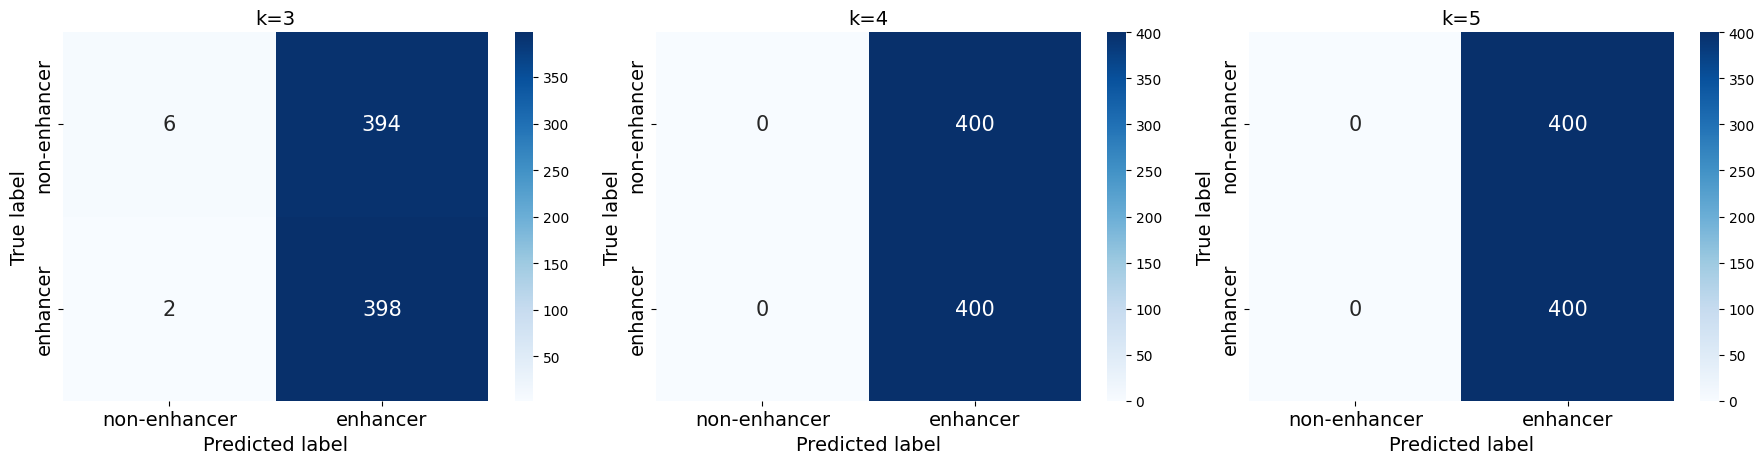

In [71]:
plot_confusion_matrices_for_model(results_exp, "Logistic Regression", ["non-enhancer", "enhancer"])

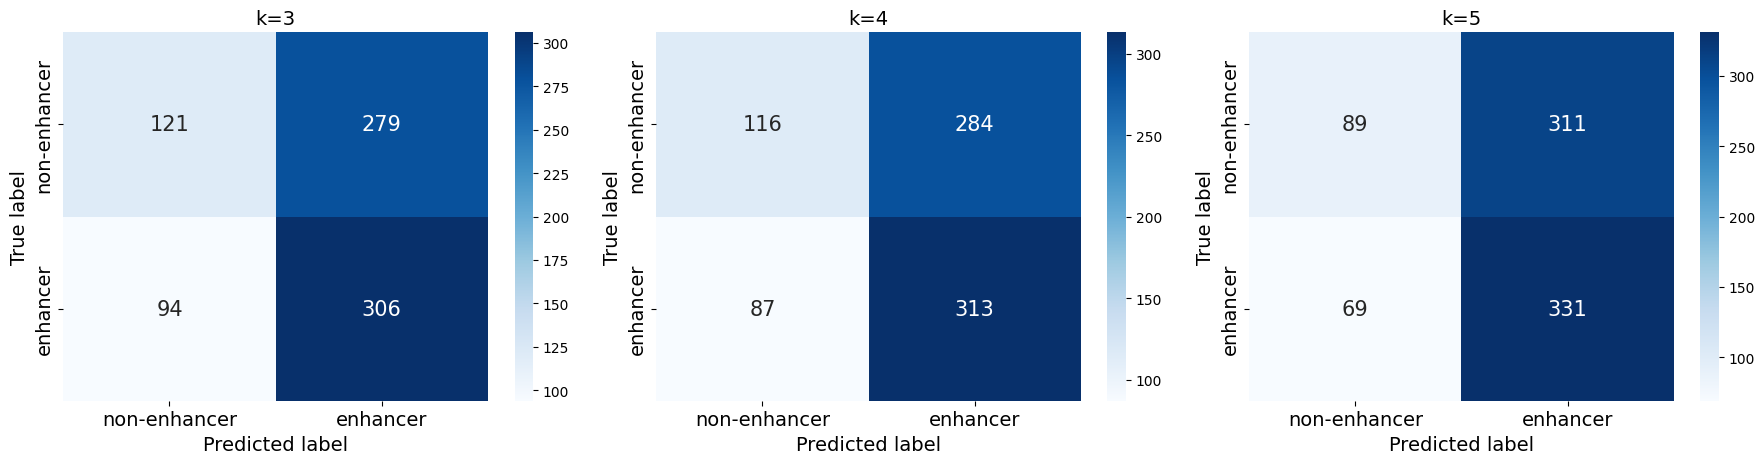

In [72]:
plot_confusion_matrices_for_model(results_exp, "Random Forest", ["non-enhancer", "enhancer"])

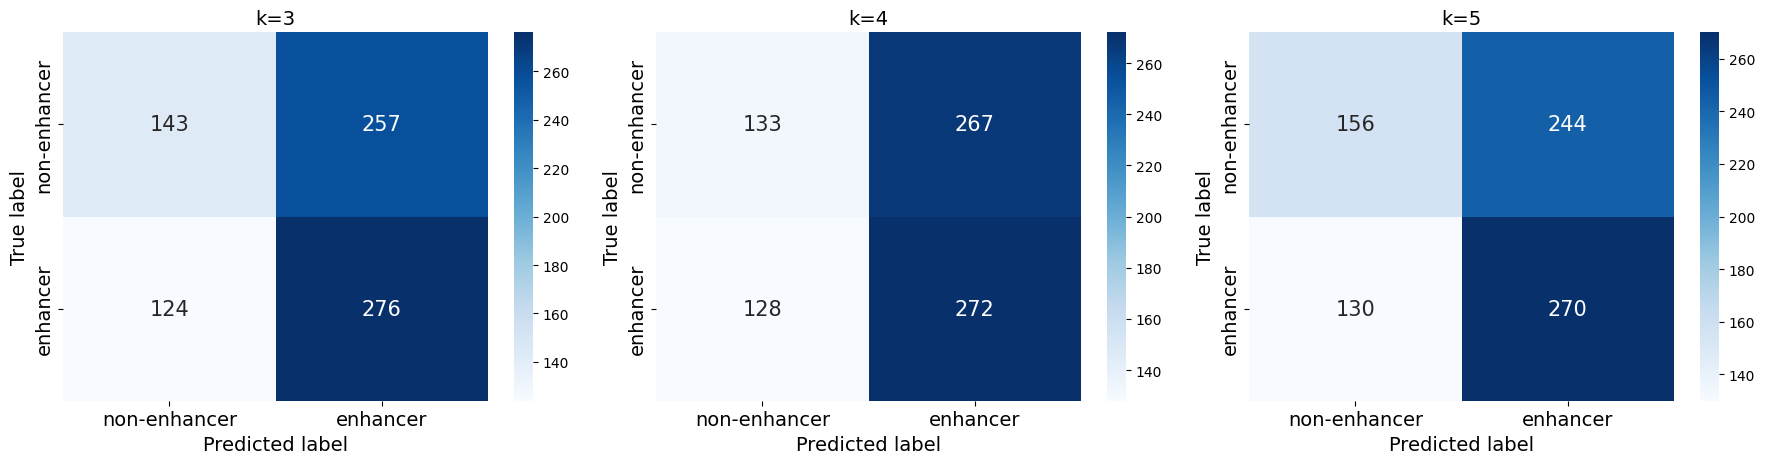

In [73]:
plot_confusion_matrices_for_model(results_exp, "XGBoost", ["non-enhancer", "enhancer"])

#### Random sequences from the entire genome

In [23]:
train, test = split_train_test(positive, random_negative)
results_rnd = {}

In [24]:
for k in k_values:
    print(f"\nTraining models for k={k}\n")
    results_k = train_models(train, test, models, params, k_=k)
    results_rnd[k] = results_k 


Training models for k=3
Model:  Logistic Regression
Model:  Random Forest
Model:  XGBoost

Training models for k=4
Model:  Logistic Regression
Model:  Random Forest
Model:  XGBoost

Training models for k=5
Model:  Logistic Regression
Model:  Random Forest
Model:  XGBoost


In [25]:
for k, results_k in results_rnd.items():
    print(f"Results for k={k}")
    df = pd.DataFrame(results_k)
    print(df)

Results for k=3
                 Model  Accuracy  Precision  Recall  F1-score   AUC-ROC  \
0  Logistic Regression   0.68875   0.695090  0.6725  0.683609  0.741650   
1        Random Forest   0.73500   0.754054  0.6975  0.724675  0.806325   
2              XGBoost   0.72625   0.740053  0.6975  0.718147  0.807125   

           Confusion matrix  
0  [[282, 118], [131, 269]]  
1   [[309, 91], [121, 279]]  
2   [[302, 98], [121, 279]]  
Results for k=4
                 Model  Accuracy  Precision  Recall  F1-score   AUC-ROC  \
0  Logistic Regression   0.68375   0.677108  0.7025  0.689571  0.758969   
1        Random Forest   0.74875   0.758442  0.7300  0.743949  0.824412   
2              XGBoost   0.73875   0.754667  0.7075  0.730323  0.818131   

           Confusion matrix  
0  [[266, 134], [119, 281]]  
1   [[307, 93], [108, 292]]  
2   [[308, 92], [117, 283]]  
Results for k=5
                 Model  Accuracy  Precision  Recall  F1-score   AUC-ROC  \
0  Logistic Regression   0.69000   

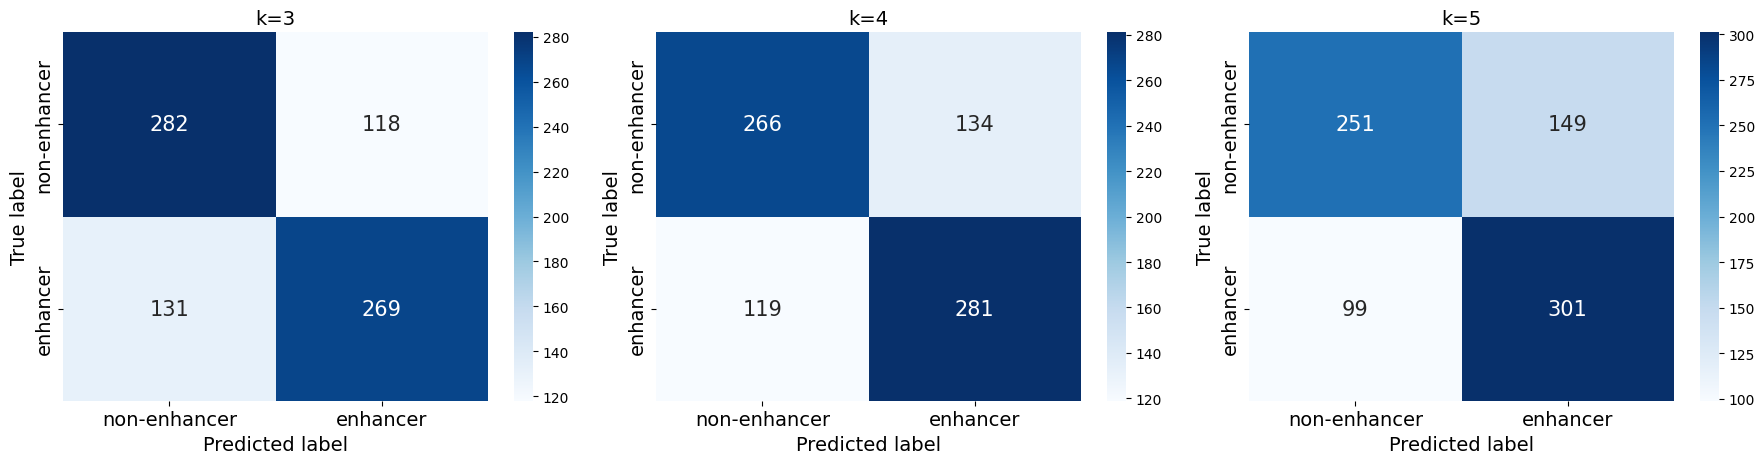

In [74]:
plot_confusion_matrices_for_model(results_rnd, "Logistic Regression", ["non-enhancer", "enhancer"])

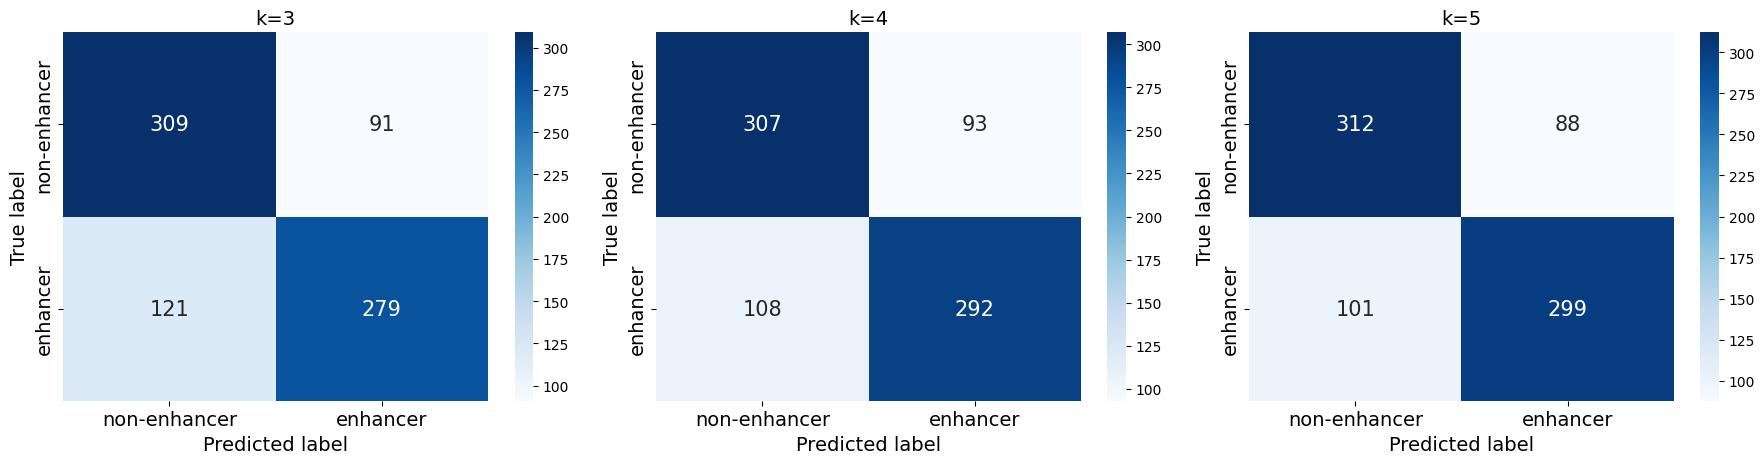

In [75]:
plot_confusion_matrices_for_model(results_rnd, "Random Forest", ["non-enhancer", "enhancer"])

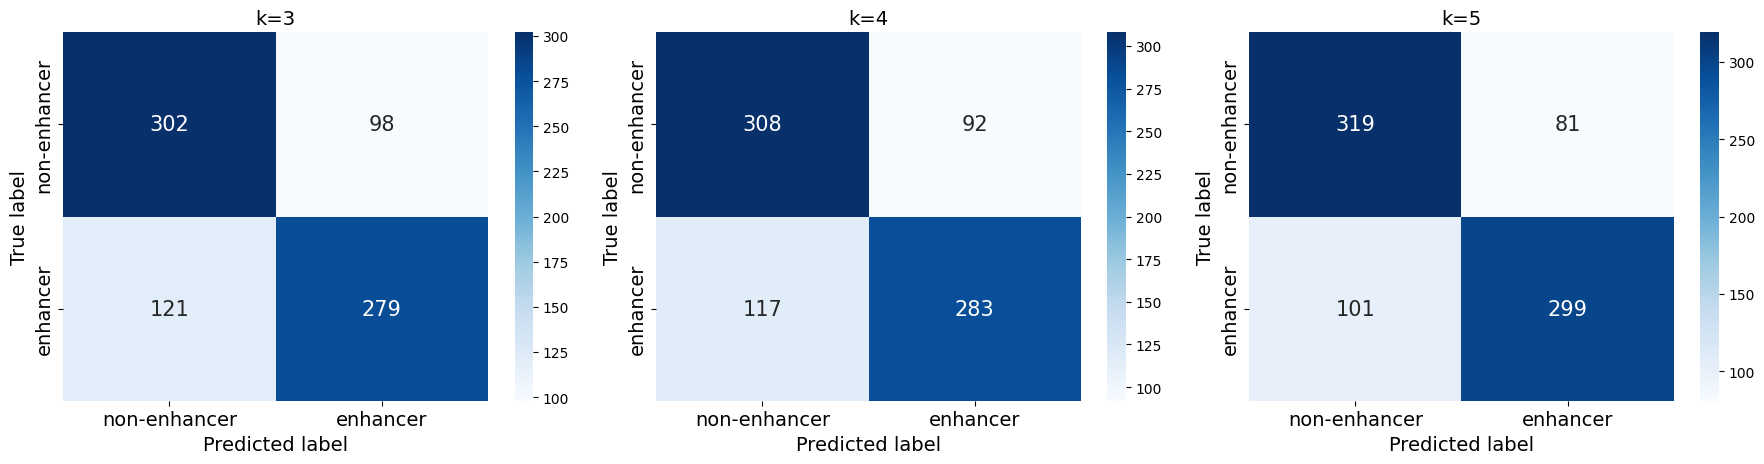

In [76]:
plot_confusion_matrices_for_model(results_rnd, "XGBoost", ["non-enhancer", "enhancer"])